In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from tensorflow import keras

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/potatodisease/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

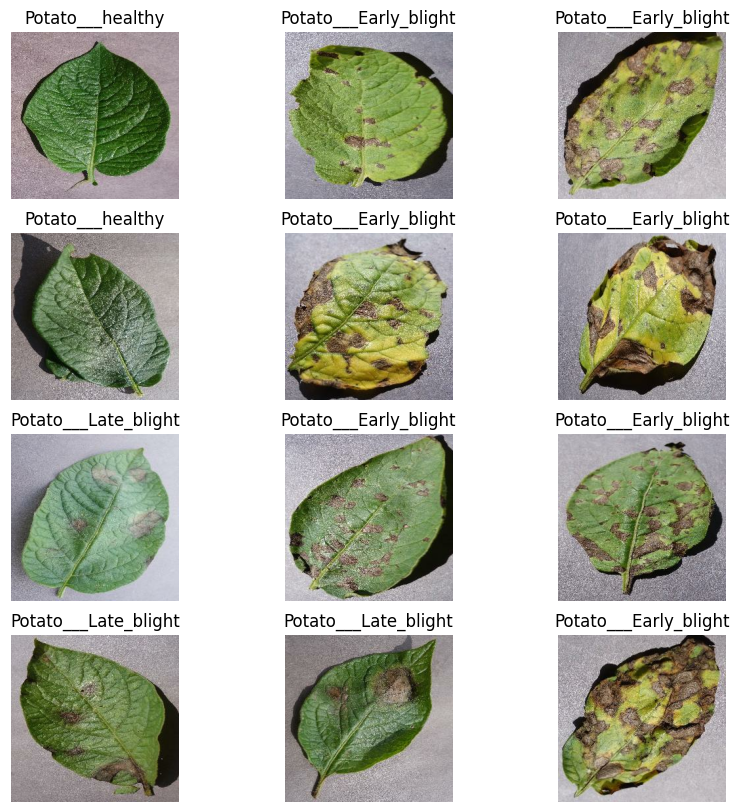

In [7]:
plt.figure(figsize=((10,10)))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(classes[label_batch[i]])

In [8]:
print(image_batch.shape)
print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 0 2 0 0 1 0 0 1 1 0 0 0 2 0 1 2 1 0 0 0 0 1 1 0 1 1 0 0 0 0]


In [9]:
train_size_frac = 0.8
train_size = len(dataset)*train_size_frac
train_size

54.400000000000006

In [10]:
train_ds = dataset.take(int(train_size))
len(train_ds)

54

In [11]:
test_ds = dataset.skip(int(train_size))
len(test_ds)

14

In [12]:
val_size_frac = 0.1
val_size = len(dataset)*val_size_frac

In [13]:
val_ds = test_ds.take(6)
len(val_ds)
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_rescale = keras.Sequential([
    keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.Rescaling(1.0/255)
])

In [17]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2)
])

In [18]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 [==============================] - 137s 2s/step - loss: 0.9148 - accuracy: 0.4734 - val_loss: 0.8886 - val_accuracy: 0.7344
Epoch 2/30
54/54 [==============================] - 127s 2s/step - loss: 0.8108 - accuracy: 0.6123 - val_loss: 0.7644 - val_accuracy: 0.6771
Epoch 3/30
54/54 [==============================] - 128s 2s/step - loss: 0.5587 - accuracy: 0.7656 - val_loss: 0.4984 - val_accuracy: 0.8021
Epoch 4/30
54/54 [==============================] - 128s 2s/step - loss: 0.4394 - accuracy: 0.8131 - val_loss: 0.3120 - val_accuracy: 0.8646
Epoch 5/30
54/54 [==============================] - 128s 2s/step - loss: 0.3201 - accuracy: 0.8669 - val_loss: 0.2192 - val_accuracy: 0.8958
Epoch 6/30
54/54 [==============================] - 127s 2s/step - loss: 0.2610 - accuracy: 0.8987 - val_loss: 0.2746 - val_accuracy: 0.9115
Epoch 7/30
54/54 [==============================] - 127s 2s/step - loss: 0.2346 - accuracy: 0.9097 - val_loss: 0.1939 - val_accuracy: 0.9219
Epoch 8/30
54

In [22]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 7s 543ms/step - loss: 0.0839 - accuracy: 0.9569


[0.08385671675205231, 0.9568965435028076]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 800ms/step
predicted label: Potato___Early_blight


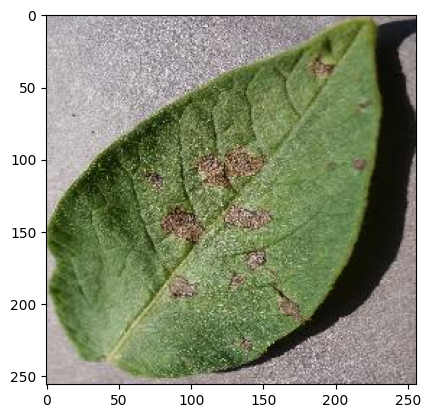

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])


In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [29]:
class_names = dataset.class_names

1/1 [==============================] - 0s 44ms/step


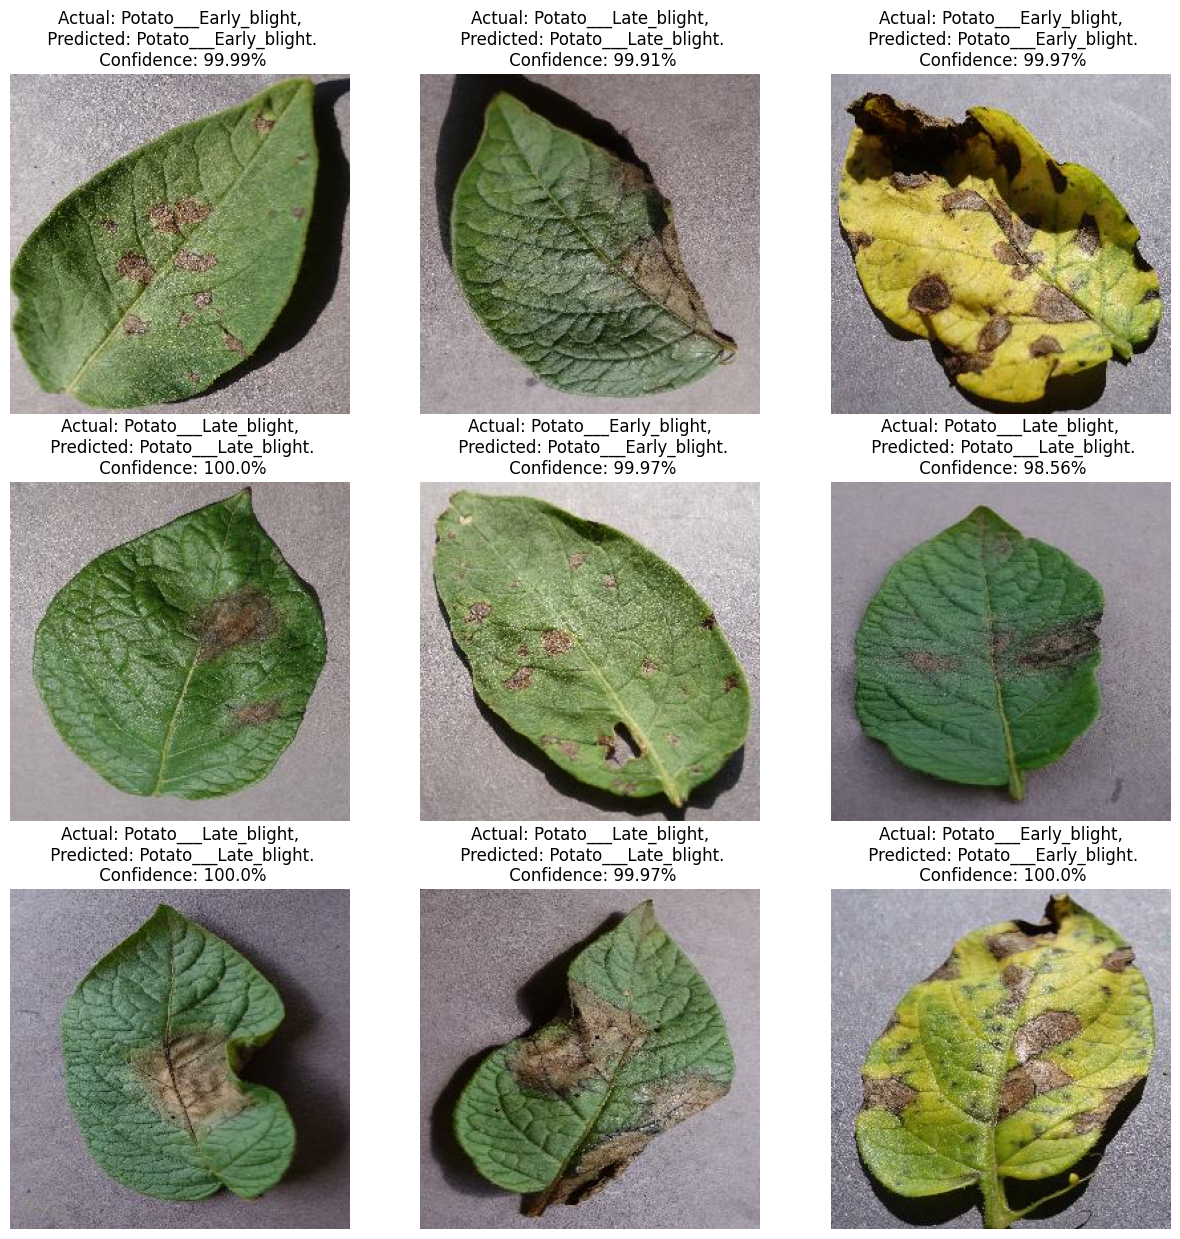

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [31]:
model.save('./v1')